## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **OLD DATASET LOADER**

In [2]:
# # Loading CIFAR 100 dataset
# def CIFAR100DataLoader(
#     split, batch_size=8, num_workers=2, shuffle=True, size="32", normalize="standard"
# ):
#     """
#     A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
#     the parameters supplied and applies the required data augmentations.

#     Args:
#         split: A string to decide if train or test data to be used (Values: 'train', 'test')
#         batch_size: Batch size to used for loading data (Default=8)
#         num_workers: Number of parallel workers used to load data (Default=2)
#         shuffle: Boolean value to decide if data should be randomized (Default=True)
#         size: A string to decide the size of the input images (Default='32') (Values: '32','224')
#         normalize: A string to decide the normalization to applied to the input images
#                    (Default='standard') (Values: 'standard', 'imagenet')

#     Output:
#         DataLoader Object
#     """
#     if normalize == "imagenet":
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#     elif normalize == "standard":
#         mean = [0.5, 0.5, 0.5]
#         std = [0.5, 0.5, 0.5]

#     if split == "train":
#         if size == "224":
#             train_transform = transforms.Compose(
#                 [
#                     transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )
#         elif size == "32":
#             train_transform = transforms.Compose(
#                 [
#                     transforms.RandomCrop(32, padding=4),
#                     transforms.RandomHorizontalFlip(),
#                     transforms.RandomRotation(15),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )

#         cifar100 = torchvision.datasets.CIFAR100(
#             root="data", train=True, download=True, transform=train_transform
#         )
#         dataloader = DataLoader(
#             cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
#         )

#     elif split == "test":
#         if size == "224":
#             test_transform = transforms.Compose(
#                 [
#                     transforms.Resize((224, 224)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )

#         elif size == "32":
#             test_transform = transforms.Compose(
#                 [transforms.ToTensor(), transforms.Normalize(mean, std)]
#             )

#         cifar100 = torchvision.datasets.CIFAR100(
#             root="./data", train=False, download=True, transform=test_transform
#         )
#         dataloader = DataLoader(
#             cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
#         )

#     return dataloader

## **NEW DATASET LOADER**

In [3]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [4]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [5]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [6]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [7]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0
    index = 0
    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)
        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [8]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 8
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 12

resnet_features_channels = 64

In [9]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [10]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:01<00:00, 84652765.56it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [12]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch8-768d-12h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch8-768d-12h-12l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
# print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [01:23<00:00, 18.80it/s]


Epoch : 1 - acc: 0.0746 - loss : 4.1268



100%|██████████| 313/313 [00:05<00:00, 58.51it/s]


test acc: 0.1135 - test loss : 3.8337



100%|██████████| 1563/1563 [01:26<00:00, 18.08it/s]


Epoch : 2 - acc: 0.1189 - loss : 3.7874



100%|██████████| 313/313 [00:05<00:00, 56.08it/s]


test acc: 0.1447 - test loss : 3.6481



100%|██████████| 1563/1563 [01:28<00:00, 17.71it/s]


Epoch : 3 - acc: 0.1474 - loss : 3.6119



100%|██████████| 313/313 [00:05<00:00, 54.33it/s]


test acc: 0.1729 - test loss : 3.4819



100%|██████████| 1563/1563 [01:29<00:00, 17.50it/s]


Epoch : 4 - acc: 0.1649 - loss : 3.4913



100%|██████████| 313/313 [00:05<00:00, 53.84it/s]


test acc: 0.1826 - test loss : 3.4193



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 5 - acc: 0.1867 - loss : 3.3809



100%|██████████| 313/313 [00:05<00:00, 54.45it/s]


test acc: 0.2109 - test loss : 3.3031



100%|██████████| 1563/1563 [01:29<00:00, 17.46it/s]


Epoch : 6 - acc: 0.1982 - loss : 3.3025



100%|██████████| 313/313 [00:05<00:00, 54.32it/s]


test acc: 0.2122 - test loss : 3.2554



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 7 - acc: 0.2114 - loss : 3.2350



100%|██████████| 313/313 [00:05<00:00, 54.25it/s]


test acc: 0.2270 - test loss : 3.1825



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 8 - acc: 0.2199 - loss : 3.1811



100%|██████████| 313/313 [00:05<00:00, 54.13it/s]


test acc: 0.2349 - test loss : 3.1358



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 9 - acc: 0.2290 - loss : 3.1346



100%|██████████| 313/313 [00:05<00:00, 54.13it/s]


test acc: 0.2466 - test loss : 3.1036



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 10 - acc: 0.2375 - loss : 3.0890



100%|██████████| 313/313 [00:05<00:00, 54.16it/s]


test acc: 0.2422 - test loss : 3.0976



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 11 - acc: 0.2431 - loss : 3.0553



100%|██████████| 313/313 [00:05<00:00, 54.22it/s]


test acc: 0.2590 - test loss : 3.0383



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 12 - acc: 0.2506 - loss : 3.0163



100%|██████████| 313/313 [00:05<00:00, 54.09it/s]


test acc: 0.2566 - test loss : 3.0518



100%|██████████| 1563/1563 [01:29<00:00, 17.40it/s]


Epoch : 13 - acc: 0.2594 - loss : 2.9800



100%|██████████| 313/313 [00:05<00:00, 54.20it/s]


test acc: 0.2539 - test loss : 3.0221



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 14 - acc: 0.2626 - loss : 2.9492



100%|██████████| 313/313 [00:05<00:00, 54.21it/s]


test acc: 0.2605 - test loss : 3.0099



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 15 - acc: 0.2715 - loss : 2.9166



100%|██████████| 313/313 [00:05<00:00, 54.05it/s]


test acc: 0.2723 - test loss : 2.9665



100%|██████████| 1563/1563 [01:29<00:00, 17.47it/s]


Epoch : 16 - acc: 0.2776 - loss : 2.8764



100%|██████████| 313/313 [00:05<00:00, 54.11it/s]


test acc: 0.2812 - test loss : 2.9571



100%|██████████| 1563/1563 [01:29<00:00, 17.46it/s]


Epoch : 17 - acc: 0.2800 - loss : 2.8681



100%|██████████| 313/313 [00:05<00:00, 54.27it/s]


test acc: 0.2750 - test loss : 2.9359



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 18 - acc: 0.2844 - loss : 2.8321



100%|██████████| 313/313 [00:05<00:00, 54.47it/s]


test acc: 0.2817 - test loss : 2.9219



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 19 - acc: 0.2908 - loss : 2.8076



100%|██████████| 313/313 [00:05<00:00, 54.28it/s]


test acc: 0.2868 - test loss : 2.9127



100%|██████████| 1563/1563 [01:29<00:00, 17.47it/s]


Epoch : 20 - acc: 0.2962 - loss : 2.7828



100%|██████████| 313/313 [00:05<00:00, 54.31it/s]


test acc: 0.2907 - test loss : 2.8872



100%|██████████| 1563/1563 [01:29<00:00, 17.49it/s]


Epoch : 21 - acc: 0.3001 - loss : 2.7524



100%|██████████| 313/313 [00:05<00:00, 54.44it/s]


test acc: 0.2890 - test loss : 2.8986



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 22 - acc: 0.3049 - loss : 2.7282



100%|██████████| 313/313 [00:05<00:00, 54.40it/s]


test acc: 0.2911 - test loss : 2.8660



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 23 - acc: 0.3095 - loss : 2.7091



100%|██████████| 313/313 [00:05<00:00, 54.35it/s]


test acc: 0.2939 - test loss : 2.8604



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 24 - acc: 0.3141 - loss : 2.6847



100%|██████████| 313/313 [00:05<00:00, 54.31it/s]


test acc: 0.2923 - test loss : 2.8695



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 25 - acc: 0.3190 - loss : 2.6641



100%|██████████| 313/313 [00:05<00:00, 54.36it/s]


test acc: 0.2976 - test loss : 2.8462



100%|██████████| 1563/1563 [01:29<00:00, 17.40it/s]


Epoch : 26 - acc: 0.3239 - loss : 2.6362



100%|██████████| 313/313 [00:05<00:00, 53.99it/s]


test acc: 0.3052 - test loss : 2.8221



100%|██████████| 1563/1563 [01:29<00:00, 17.37it/s]


Epoch : 27 - acc: 0.3288 - loss : 2.6151



100%|██████████| 313/313 [00:05<00:00, 53.84it/s]


test acc: 0.3062 - test loss : 2.8545



100%|██████████| 1563/1563 [01:30<00:00, 17.36it/s]


Epoch : 28 - acc: 0.3314 - loss : 2.5904



100%|██████████| 313/313 [00:05<00:00, 53.90it/s]


test acc: 0.3029 - test loss : 2.8390



100%|██████████| 1563/1563 [01:30<00:00, 17.32it/s]


Epoch : 29 - acc: 0.3386 - loss : 2.5696



100%|██████████| 313/313 [00:05<00:00, 54.00it/s]


test acc: 0.3063 - test loss : 2.8208



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 30 - acc: 0.3396 - loss : 2.5555



100%|██████████| 313/313 [00:05<00:00, 53.70it/s]


test acc: 0.3091 - test loss : 2.7998



100%|██████████| 1563/1563 [01:29<00:00, 17.37it/s]


Epoch : 31 - acc: 0.3436 - loss : 2.5360



100%|██████████| 313/313 [00:05<00:00, 53.82it/s]


test acc: 0.3135 - test loss : 2.8117



100%|██████████| 1563/1563 [01:30<00:00, 17.35it/s]


Epoch : 32 - acc: 0.3464 - loss : 2.5248



100%|██████████| 313/313 [00:05<00:00, 53.96it/s]


test acc: 0.3136 - test loss : 2.8177



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 33 - acc: 0.3499 - loss : 2.5021



100%|██████████| 313/313 [00:05<00:00, 53.93it/s]


test acc: 0.3134 - test loss : 2.7983



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 34 - acc: 0.3554 - loss : 2.4789



100%|██████████| 313/313 [00:05<00:00, 54.07it/s]


test acc: 0.3171 - test loss : 2.8021



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 35 - acc: 0.3589 - loss : 2.4656



100%|██████████| 313/313 [00:05<00:00, 53.99it/s]


test acc: 0.3171 - test loss : 2.7978



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 36 - acc: 0.3605 - loss : 2.4474



100%|██████████| 313/313 [00:05<00:00, 54.13it/s]


test acc: 0.3173 - test loss : 2.7960



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 37 - acc: 0.3661 - loss : 2.4199



100%|██████████| 313/313 [00:05<00:00, 54.11it/s]


test acc: 0.3188 - test loss : 2.7734



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 38 - acc: 0.3694 - loss : 2.4125



100%|██████████| 313/313 [00:05<00:00, 54.19it/s]


test acc: 0.3184 - test loss : 2.7958



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 39 - acc: 0.3722 - loss : 2.3902



100%|██████████| 313/313 [00:05<00:00, 54.08it/s]


test acc: 0.3190 - test loss : 2.7750



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 40 - acc: 0.3772 - loss : 2.3787



100%|██████████| 313/313 [00:05<00:00, 54.21it/s]


test acc: 0.3246 - test loss : 2.7777



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 41 - acc: 0.3797 - loss : 2.3550



100%|██████████| 313/313 [00:05<00:00, 54.60it/s]


test acc: 0.3269 - test loss : 2.7641



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 42 - acc: 0.3865 - loss : 2.3395



100%|██████████| 313/313 [00:05<00:00, 53.99it/s]


test acc: 0.3219 - test loss : 2.7768



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 43 - acc: 0.3854 - loss : 2.3306



100%|██████████| 313/313 [00:05<00:00, 54.08it/s]


test acc: 0.3331 - test loss : 2.7590



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 44 - acc: 0.3877 - loss : 2.3165



100%|██████████| 313/313 [00:05<00:00, 54.22it/s]


test acc: 0.3348 - test loss : 2.7675



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 45 - acc: 0.3912 - loss : 2.2909



100%|██████████| 313/313 [00:05<00:00, 54.16it/s]


test acc: 0.3328 - test loss : 2.7605



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 46 - acc: 0.3991 - loss : 2.2710



100%|██████████| 313/313 [00:05<00:00, 53.96it/s]


test acc: 0.3353 - test loss : 2.7590



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 47 - acc: 0.3983 - loss : 2.2589



100%|██████████| 313/313 [00:05<00:00, 53.95it/s]


test acc: 0.3365 - test loss : 2.7558



100%|██████████| 1563/1563 [01:29<00:00, 17.38it/s]


Epoch : 48 - acc: 0.4021 - loss : 2.2495



100%|██████████| 313/313 [00:05<00:00, 54.17it/s]


test acc: 0.3279 - test loss : 2.7626



100%|██████████| 1563/1563 [01:29<00:00, 17.40it/s]


Epoch : 49 - acc: 0.4053 - loss : 2.2319



100%|██████████| 313/313 [00:05<00:00, 54.38it/s]


test acc: 0.3300 - test loss : 2.7740



100%|██████████| 1563/1563 [01:29<00:00, 17.37it/s]


Epoch : 50 - acc: 0.4074 - loss : 2.2141



100%|██████████| 313/313 [00:05<00:00, 54.51it/s]


test acc: 0.3311 - test loss : 2.7795



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 51 - acc: 0.4071 - loss : 2.2109



100%|██████████| 313/313 [00:05<00:00, 54.40it/s]


test acc: 0.3326 - test loss : 2.7730



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 52 - acc: 0.4127 - loss : 2.1921



100%|██████████| 313/313 [00:05<00:00, 54.27it/s]


test acc: 0.3362 - test loss : 2.7627



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 53 - acc: 0.4177 - loss : 2.1688



100%|██████████| 313/313 [00:05<00:00, 53.90it/s]


test acc: 0.3379 - test loss : 2.7559



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 54 - acc: 0.4223 - loss : 2.1557



100%|██████████| 313/313 [00:05<00:00, 54.08it/s]


test acc: 0.3359 - test loss : 2.7481



100%|██████████| 1563/1563 [01:29<00:00, 17.46it/s]


Epoch : 55 - acc: 0.4246 - loss : 2.1373



100%|██████████| 313/313 [00:05<00:00, 54.16it/s]


test acc: 0.3414 - test loss : 2.7514



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 56 - acc: 0.4253 - loss : 2.1338



100%|██████████| 313/313 [00:05<00:00, 54.32it/s]


test acc: 0.3352 - test loss : 2.7857



100%|██████████| 1563/1563 [01:29<00:00, 17.50it/s]


Epoch : 57 - acc: 0.4325 - loss : 2.1041



100%|██████████| 313/313 [00:05<00:00, 54.34it/s]


test acc: 0.3417 - test loss : 2.7737



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 58 - acc: 0.4354 - loss : 2.0974



100%|██████████| 313/313 [00:05<00:00, 54.55it/s]


test acc: 0.3405 - test loss : 2.7825



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 59 - acc: 0.4373 - loss : 2.0838



100%|██████████| 313/313 [00:05<00:00, 54.33it/s]


test acc: 0.3414 - test loss : 2.7586



100%|██████████| 1563/1563 [01:29<00:00, 17.47it/s]


Epoch : 60 - acc: 0.4410 - loss : 2.0660



100%|██████████| 313/313 [00:05<00:00, 54.40it/s]


test acc: 0.3439 - test loss : 2.7803



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 61 - acc: 0.4435 - loss : 2.0540



100%|██████████| 313/313 [00:05<00:00, 54.44it/s]


test acc: 0.3397 - test loss : 2.7953



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 62 - acc: 0.4460 - loss : 2.0343



100%|██████████| 313/313 [00:05<00:00, 54.20it/s]


test acc: 0.3514 - test loss : 2.7382



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 63 - acc: 0.4523 - loss : 2.0160



100%|██████████| 313/313 [00:05<00:00, 53.81it/s]


test acc: 0.3408 - test loss : 2.7645



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 64 - acc: 0.4507 - loss : 2.0090



100%|██████████| 313/313 [00:05<00:00, 53.73it/s]


test acc: 0.3406 - test loss : 2.8087



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 65 - acc: 0.4587 - loss : 1.9879



100%|██████████| 313/313 [00:05<00:00, 54.29it/s]


test acc: 0.3437 - test loss : 2.7892



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 66 - acc: 0.4611 - loss : 1.9756



100%|██████████| 313/313 [00:05<00:00, 54.06it/s]


test acc: 0.3388 - test loss : 2.7962



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 67 - acc: 0.4634 - loss : 1.9593



100%|██████████| 313/313 [00:05<00:00, 54.08it/s]


test acc: 0.3463 - test loss : 2.8046



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 68 - acc: 0.4666 - loss : 1.9431



100%|██████████| 313/313 [00:05<00:00, 54.05it/s]


test acc: 0.3399 - test loss : 2.8355



100%|██████████| 1563/1563 [01:30<00:00, 17.36it/s]


Epoch : 69 - acc: 0.4680 - loss : 1.9367



100%|██████████| 313/313 [00:05<00:00, 54.01it/s]


test acc: 0.3410 - test loss : 2.8262



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 70 - acc: 0.4666 - loss : 1.9315



100%|██████████| 313/313 [00:05<00:00, 53.68it/s]


test acc: 0.3469 - test loss : 2.8080



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 71 - acc: 0.4721 - loss : 1.9072



100%|██████████| 313/313 [00:05<00:00, 53.88it/s]


test acc: 0.3442 - test loss : 2.8340



100%|██████████| 1563/1563 [01:29<00:00, 17.40it/s]


Epoch : 72 - acc: 0.4768 - loss : 1.8910



100%|██████████| 313/313 [00:05<00:00, 54.07it/s]


test acc: 0.3390 - test loss : 2.8730



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 73 - acc: 0.4808 - loss : 1.8799



100%|██████████| 313/313 [00:05<00:00, 54.11it/s]


test acc: 0.3483 - test loss : 2.8432



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 74 - acc: 0.4849 - loss : 1.8566



100%|██████████| 313/313 [00:05<00:00, 54.02it/s]


test acc: 0.3502 - test loss : 2.8412



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 75 - acc: 0.4856 - loss : 1.8497



100%|██████████| 313/313 [00:05<00:00, 54.23it/s]


test acc: 0.3390 - test loss : 2.8670



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 76 - acc: 0.4908 - loss : 1.8239



100%|██████████| 313/313 [00:05<00:00, 54.08it/s]


test acc: 0.3461 - test loss : 2.8568



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 77 - acc: 0.4938 - loss : 1.8117



100%|██████████| 313/313 [00:05<00:00, 54.37it/s]


test acc: 0.3515 - test loss : 2.8678



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 78 - acc: 0.5007 - loss : 1.7973



100%|██████████| 313/313 [00:05<00:00, 54.31it/s]


test acc: 0.3467 - test loss : 2.8525



100%|██████████| 1563/1563 [01:29<00:00, 17.38it/s]


Epoch : 79 - acc: 0.5021 - loss : 1.7923



100%|██████████| 313/313 [00:05<00:00, 54.21it/s]


test acc: 0.3431 - test loss : 2.8809



100%|██████████| 1563/1563 [01:29<00:00, 17.38it/s]


Epoch : 80 - acc: 0.5029 - loss : 1.7740



100%|██████████| 313/313 [00:05<00:00, 54.27it/s]


test acc: 0.3517 - test loss : 2.8793



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 81 - acc: 0.5035 - loss : 1.7692



100%|██████████| 313/313 [00:05<00:00, 53.84it/s]


test acc: 0.3482 - test loss : 2.8805



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 82 - acc: 0.5038 - loss : 1.7649



100%|██████████| 313/313 [00:05<00:00, 54.23it/s]


test acc: 0.3506 - test loss : 2.8843



100%|██████████| 1563/1563 [01:29<00:00, 17.47it/s]


Epoch : 83 - acc: 0.5094 - loss : 1.7483



100%|██████████| 313/313 [00:05<00:00, 54.22it/s]


test acc: 0.3494 - test loss : 2.8707



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 84 - acc: 0.5140 - loss : 1.7293



100%|██████████| 313/313 [00:05<00:00, 54.35it/s]


test acc: 0.3436 - test loss : 2.9296



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 85 - acc: 0.5167 - loss : 1.7152



100%|██████████| 313/313 [00:05<00:00, 54.46it/s]


test acc: 0.3388 - test loss : 2.9167



100%|██████████| 1563/1563 [01:29<00:00, 17.40it/s]


Epoch : 86 - acc: 0.5189 - loss : 1.7058



100%|██████████| 313/313 [00:05<00:00, 53.58it/s]


test acc: 0.3494 - test loss : 2.9223



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 87 - acc: 0.5228 - loss : 1.6912



100%|██████████| 313/313 [00:05<00:00, 54.18it/s]


test acc: 0.3492 - test loss : 2.9110



100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch : 88 - acc: 0.5209 - loss : 1.6954



100%|██████████| 313/313 [00:05<00:00, 53.96it/s]


test acc: 0.3483 - test loss : 2.9249



100%|██████████| 1563/1563 [01:29<00:00, 17.42it/s]


Epoch : 89 - acc: 0.5227 - loss : 1.6794



100%|██████████| 313/313 [00:05<00:00, 54.02it/s]


test acc: 0.3425 - test loss : 2.9682



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 90 - acc: 0.5323 - loss : 1.6596



100%|██████████| 313/313 [00:05<00:00, 53.94it/s]


test acc: 0.3506 - test loss : 2.9551



100%|██████████| 1563/1563 [01:29<00:00, 17.50it/s]


Epoch : 91 - acc: 0.5357 - loss : 1.6411



100%|██████████| 313/313 [00:05<00:00, 54.10it/s]


test acc: 0.3481 - test loss : 2.9468



100%|██████████| 1563/1563 [01:29<00:00, 17.43it/s]


Epoch : 92 - acc: 0.5335 - loss : 1.6453



100%|██████████| 313/313 [00:05<00:00, 54.11it/s]


test acc: 0.3440 - test loss : 2.9912



100%|██████████| 1563/1563 [01:29<00:00, 17.47it/s]


Epoch : 93 - acc: 0.5401 - loss : 1.6180



100%|██████████| 313/313 [00:05<00:00, 54.17it/s]


test acc: 0.3485 - test loss : 2.9957



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 94 - acc: 0.5380 - loss : 1.6206



100%|██████████| 313/313 [00:05<00:00, 53.94it/s]


test acc: 0.3453 - test loss : 2.9718



100%|██████████| 1563/1563 [01:29<00:00, 17.48it/s]


Epoch : 95 - acc: 0.5470 - loss : 1.5942



100%|██████████| 313/313 [00:05<00:00, 54.17it/s]


test acc: 0.3459 - test loss : 2.9898



100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch : 96 - acc: 0.5408 - loss : 1.6064



100%|██████████| 313/313 [00:05<00:00, 54.12it/s]


test acc: 0.3497 - test loss : 2.9885



100%|██████████| 1563/1563 [01:29<00:00, 17.39it/s]


Epoch : 97 - acc: 0.5465 - loss : 1.5912



100%|██████████| 313/313 [00:05<00:00, 54.23it/s]


test acc: 0.3459 - test loss : 3.0235



100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch : 98 - acc: 0.5473 - loss : 1.5780



100%|██████████| 313/313 [00:05<00:00, 53.70it/s]


test acc: 0.3402 - test loss : 3.0151



100%|██████████| 1563/1563 [01:29<00:00, 17.49it/s]


Epoch : 99 - acc: 0.5543 - loss : 1.5560



100%|██████████| 313/313 [00:05<00:00, 54.27it/s]


test acc: 0.3471 - test loss : 3.0125



100%|██████████| 1563/1563 [01:29<00:00, 17.46it/s]


Epoch : 100 - acc: 0.5565 - loss : 1.5457



100%|██████████| 313/313 [00:05<00:00, 54.24it/s]


test acc: 0.3504 - test loss : 3.0402

Start Time: 1734614620.7119858
End Time: 1734624170.2430272


In [13]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

<ipython-input-14-053996e4518c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


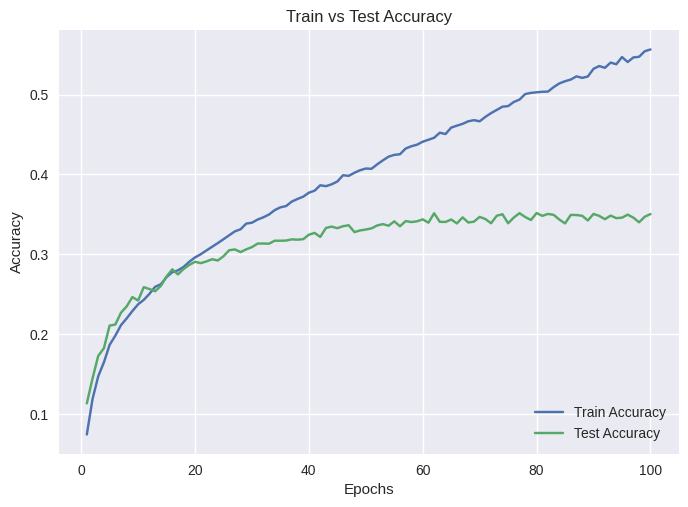

In [14]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [15]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:05<00:00, 59.16it/s]


####  Superclass confusion matrix

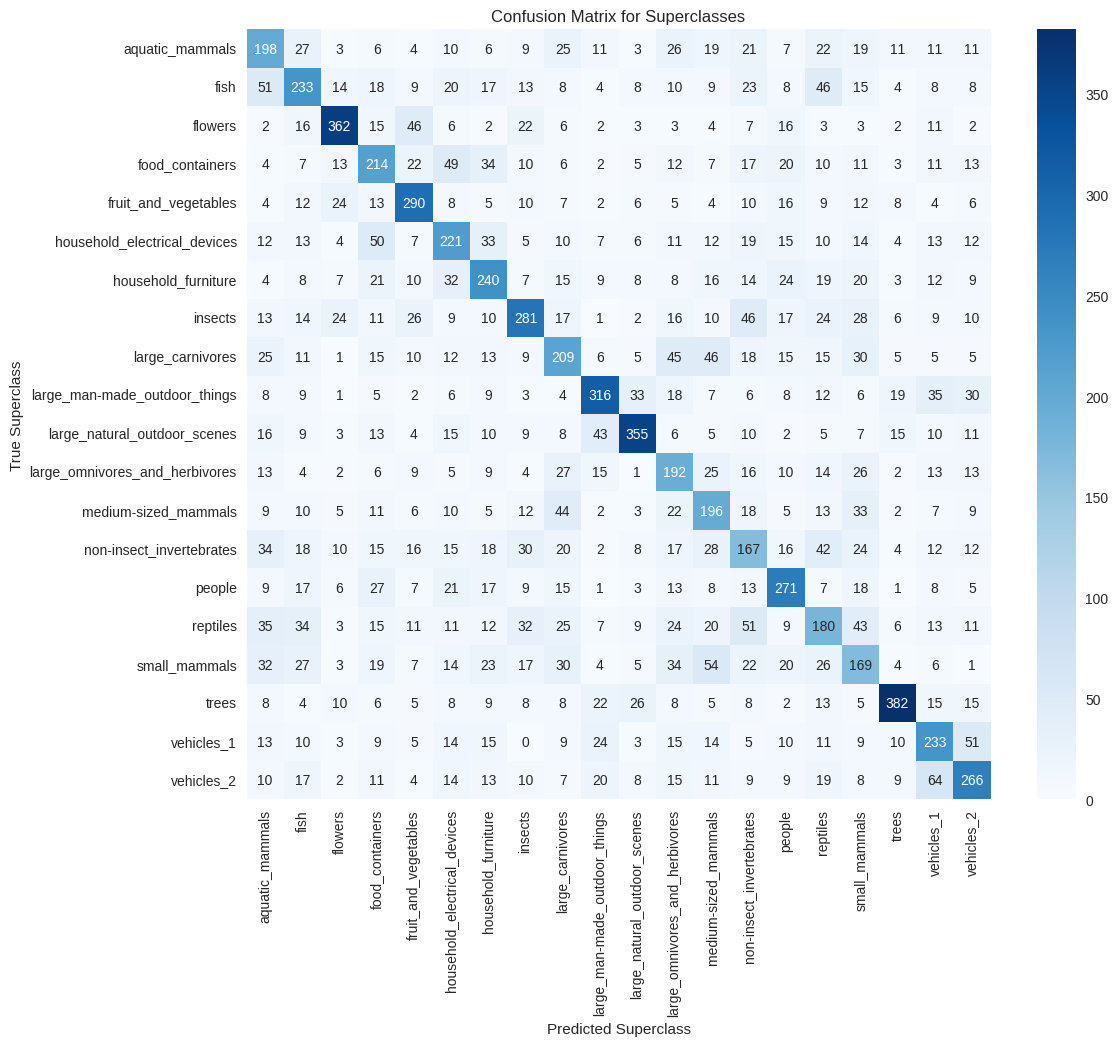

In [16]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

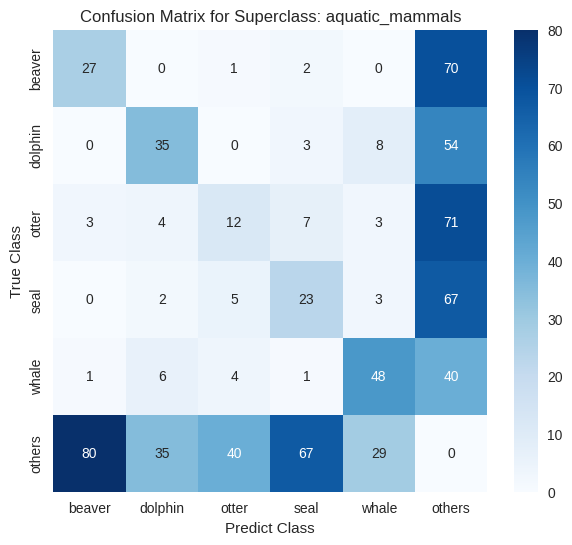

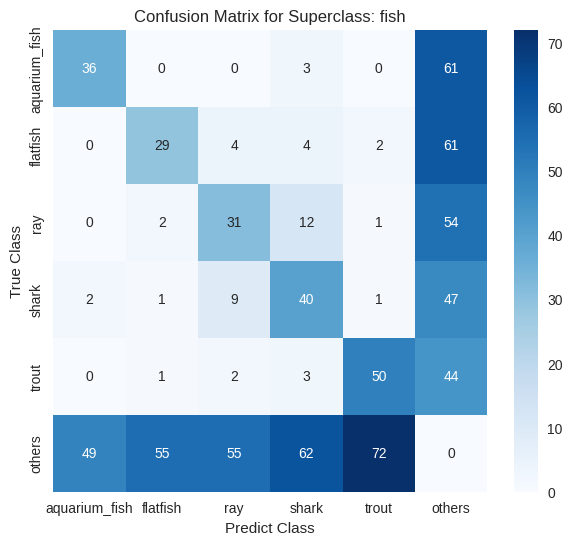

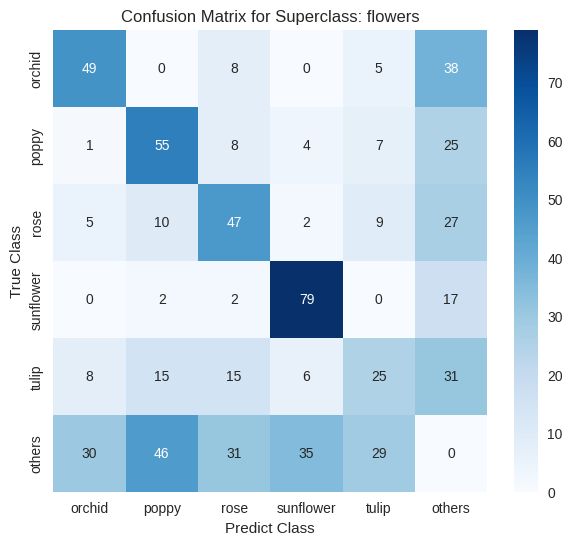

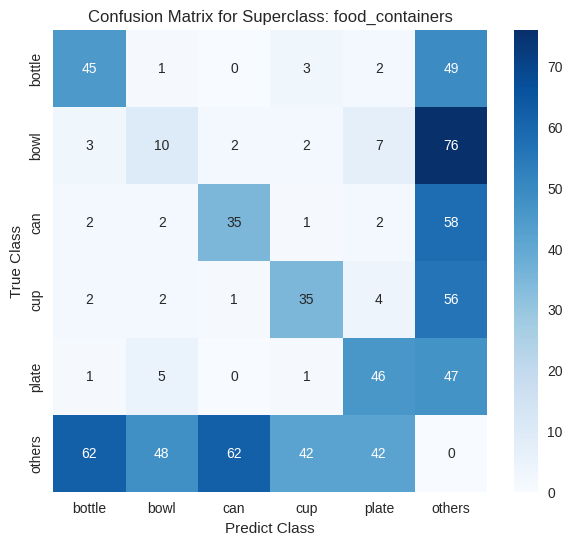

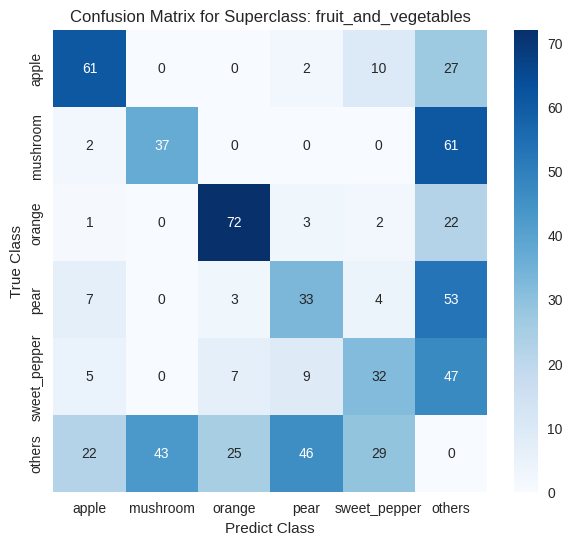

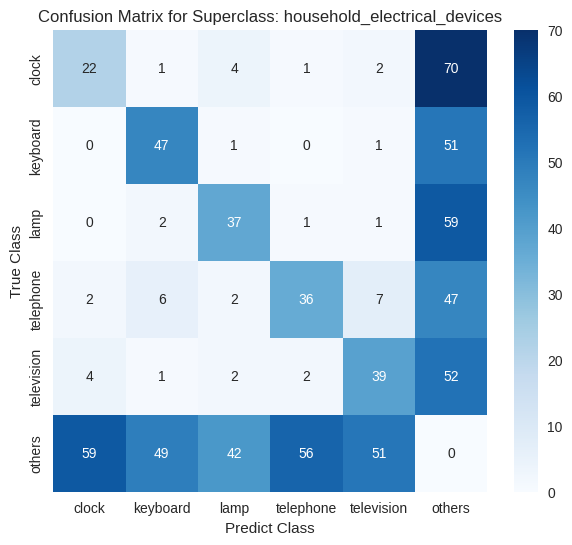

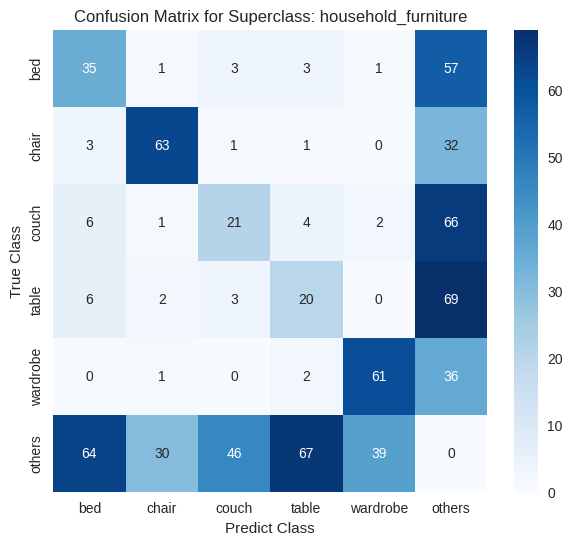

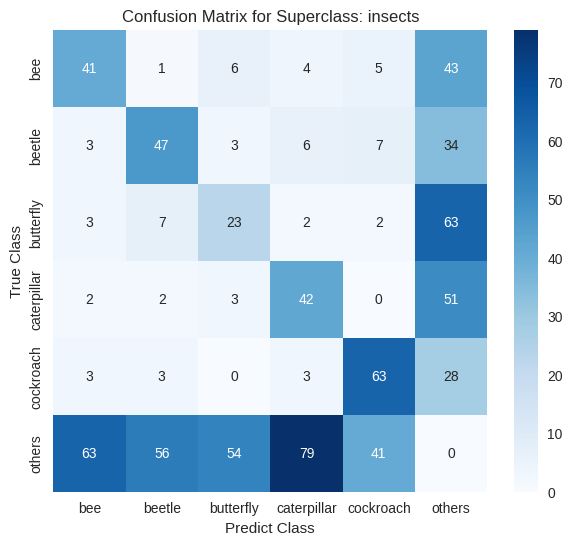

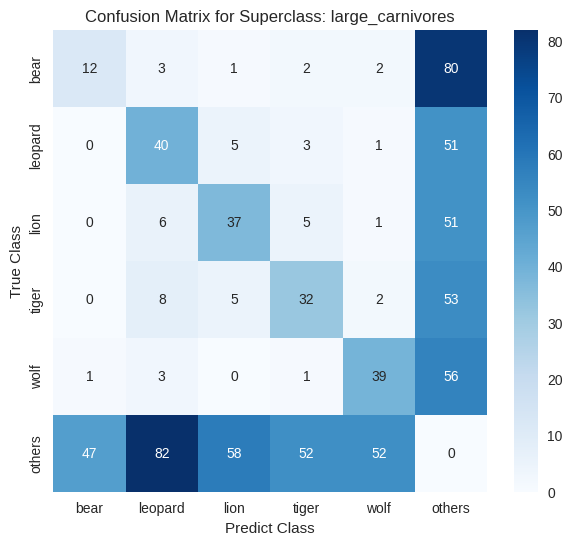

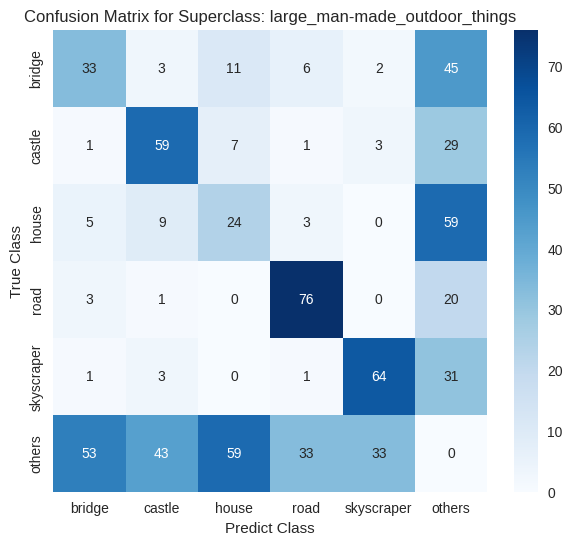

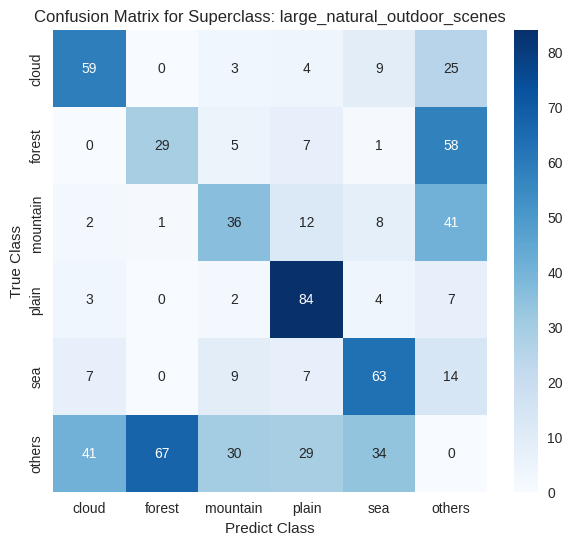

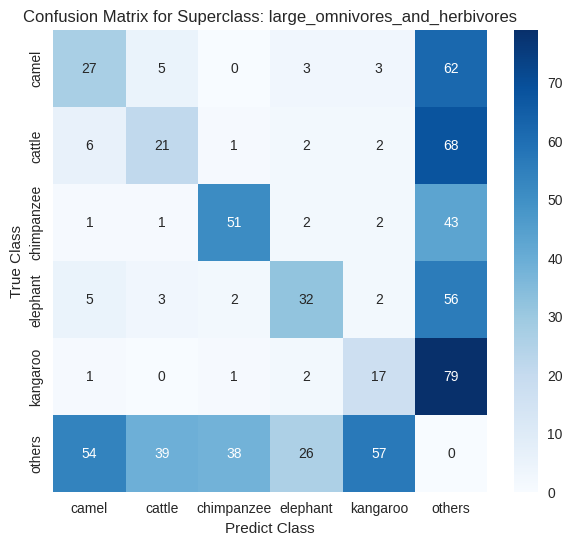

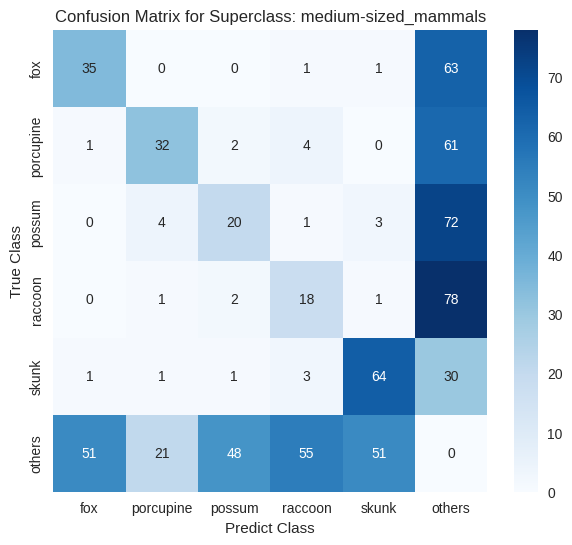

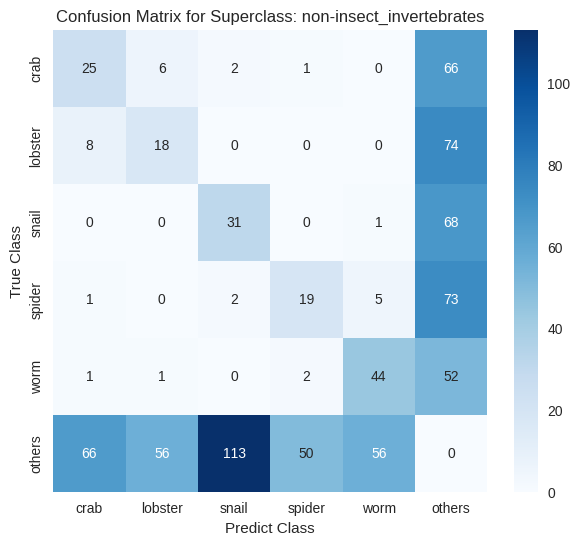

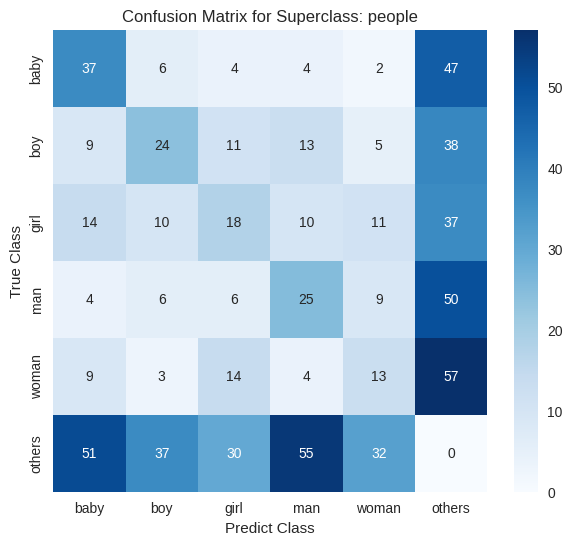

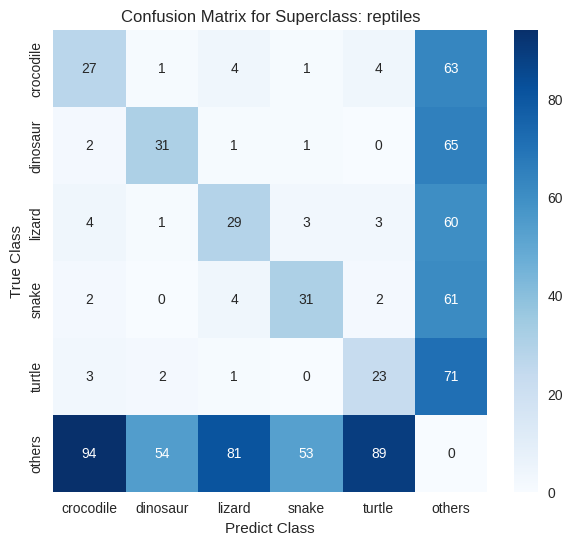

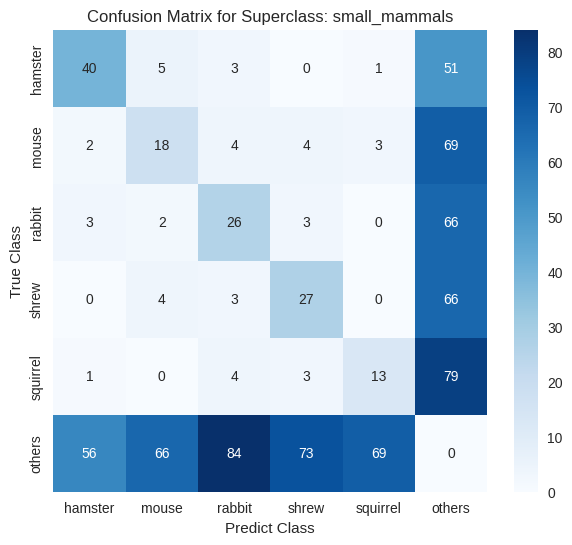

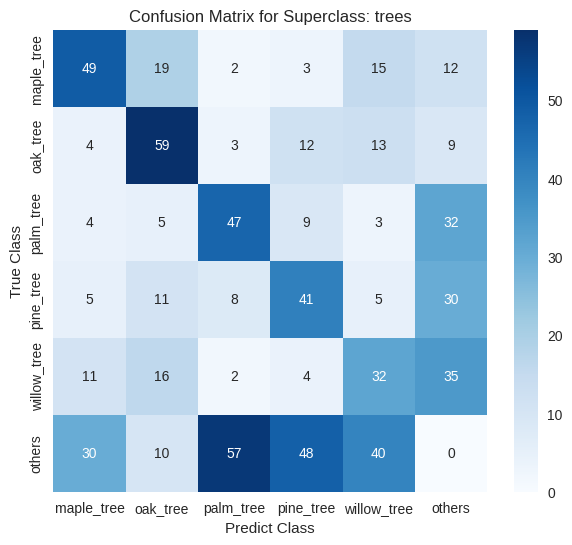

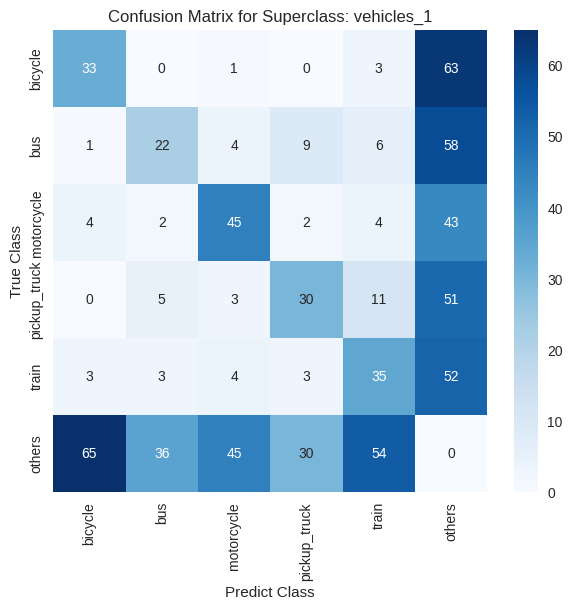

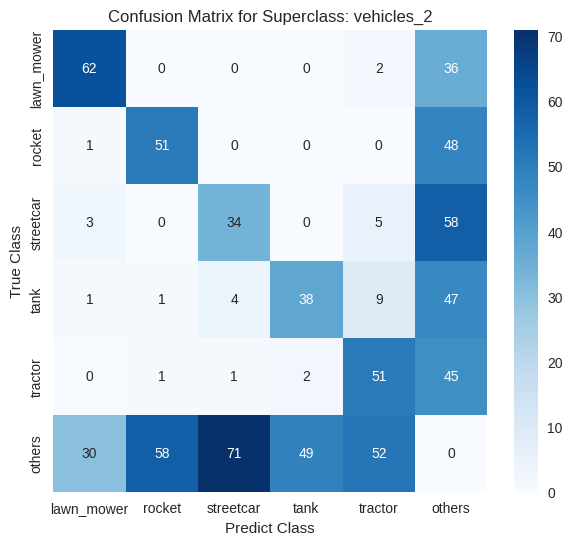

In [17]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [18]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [19]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  36.03 M 
fwd MACs:                                                               19.5085 GMACs
fwd FLOPs:                                                              39.0734 GFLOPS
fwd+bwd MACs:                                                           58.5254 GMACs
fwd+bwd FLOPs:                                                          117.22 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod